# Forecasting Traffic Volume - Creating and Evaluating Predictors: Part 2 - Related Time Series
**이 노트북의 원본은 https://github.com/chrisking/ForecastPOC.git 으로서, 원본 내용의 기반하에 추가 내용등을 기술한 버전 입니다.**

Summary: 
* Predictor 생성
    * Prophet, DeepAR+ 생성 (ARIMA는 Related Data 를 처리할 수 없기에 제외 함)
* Predictor 평가
    * Prophet, DeepAR+의 RMSE, P10, P50, P90 확인
    * Backtest 평가 기간 (12.22 ~ 12.31) 까지의 실제 Traffic Volume 확인
* Forecast 생성 및 포케스터 결과를 S3 에 업로드
    * Prophet, DeepAR+ Forecast 생성
    * Prophet 예측 결과 확인 (실제값, P10, P50, P90)
    * DeepAR 예측 결과 확인 (실제값, P10, P50, P90)
* 알고리즘 (ARIMA, Prophet, DeepAR+) 및 Related Daat 추가시의 포케스팅 결과 비교
    * Arima Vs. DeepAR+ with Target Data during Fri to Sun
    * Prophet Vs. DeepAR+ with Target Data during Fri to Sun
    * Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data during Fri to Sun
    * DeepAR+_Target Vs. DeepAR+_Target_Rel during Fri to Sun


# Creating and Evaluating Predictors: Part 2 - Related Time Series

This notebook will build off of all the ealrier work and requires that at least the importing of target time series and related time series data be complete. If you have not performed those steps yet, go back, do so, then continue.

**At this point you now have a target-time-series dataset and a related-time-series dataset loaded into a singular Dataset Group, this is what is required to leverage the models that support related data in Amazon Forecast.** If your data supports item level metadata it could be added to the dataset group as well and would benefit only DeepAR+. 

To continue the work, start with the imports, determine your region, establish your API connections, and load all previously stored values

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

ap-northeast-2


In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

In [4]:
%store -r

## Creating and Training Predictors
 
Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on Prophet and DeepAR+ respectfully.


In [5]:
forecastHorizon = 240 # 예측할 시간의 갯수 (240시간 == 10일)
NumberOfBacktestWindows = 1 # Backtest를 하는 횟수
BackTestWindowOffset = 240 # Backtest의 평가(Evaluation)의 갯수
ForecastFrequency = "H"

In [6]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

### Prophet

In [7]:
# Prophet Specifics
# Note the REL to indicate related time series data
prophet_predictorName= project+'_prophet_rel_algo_1'

In [8]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




### DeepAR+

In [ ]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_rel_algo_1'

In [12]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





Normally in our notebooks we would have a while loop that polls for each of these to determine the status of the models in training. For simplicity sake here we are going to rely on you opening a new browser tab and following along in the console until a predictor has been created for each algorithm. 

Your previous tab from opening this session of Jupyter Lab should still be open, from there navigate to the Amazon Forecast service page, then select your dataset group. Lastly click `Predictors` and you should see the creation in progress. Once they are active you are ready to continue.

In [13]:
# Wait until Predictor status is Active
prophet_arn = prophet_create_predictor_response['PredictorArn']
deeparp_arn = deeparp_create_predictor_response['PredictorArn']

while True:
    prophet_predictor_status = forecast.describe_predictor(PredictorArn=prophet_arn)['Status']
    print("PROPHET PREDICTOR STATUS: " + prophet_predictor_status)
    deeparp_predictor_status = forecast.describe_predictor(PredictorArn=deeparp_arn)['Status']
    print("DEEPARP PREDICTOR STATUS: " + deeparp_predictor_status)
    print("-----------------------------------------------------------")
    
    if prophet_predictor_status == 'ACTIVE' and deeparp_predictor_status == 'ACTIVE':
        break
    else:
        sleep(120)

prophet_predictor_metrics = forecast.describe_predictor(PredictorArn=prophet_arn)
deeparp_predictor_metrics = forecast.describe_predictor(PredictorArn=deeparp_arn)

# Print time spent for training
prophet_trainig_time = prophet_predictor_metrics["LastModificationTime"] - prophet_predictor_metrics["CreationTime"]
deeparp_trainig_time = deeparp_predictor_metrics["LastModificationTime"] - deeparp_predictor_metrics["CreationTime"]
print("PROPHET TRAINING TIME: " + str(prophet_trainig_time))
print("DEEP AR+ TRAINING TIME: " + str(deeparp_trainig_time))

PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_PENDING
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: ACTIVE
DEEPA

**아래와 같이 추가적인 2개의 Predictors (Prophet + Rel, DeepAR + Rel)가 보여야 합니다.**

![RelatedPredictors](static/imgs/RelationPredictor.png)

## Examining the Predictors

Once each of the Predictors is in an `Active` state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast

### Prophet

Here we are going to look to see the metrics from this Predictor like the earlier sessions, we will now add the related data metrics to the table from the previous notebook as well.

In [14]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1785.2505659710623,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2496444639316159,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.4307241068369345,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.17242793131744907,
                                                                                          'Quantile': 0.1}]}},
                                             

### DeepAR+

Same as Prophet, now you should look at the metrics from it.

In [15]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1579.5183163520373,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.16079145276224463,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.364426480825759,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.18065715043581954,
                                                                                          'Quantile': 0.1}]}},
                                        

## 포케스트 생성하기

In [16]:
print(prophet_arn)

arn:aws:forecast:ap-northeast-2:180246855724:predictor/forecast_poc_cwk_prophet_rel_algo_1


In [17]:
# Prophet
prophet_forecastName = project+'_prophet_rel_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [18]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_rel_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

In [19]:
# Wait until Forecast status is Active

while True:
    prophet_forecast_status = forecast.describe_forecast(ForecastArn=prophet_forecast_arn)['Status']
    print("PROPHET PREDICTOR STATUS: " + prophet_forecast_status)
    deeparp_forecast_status = forecast.describe_forecast(ForecastArn=deeparp_forecast_arn)['Status']
    print("DEEPARP PREDICTOR STATUS: " + deeparp_forecast_status)
    print("-----------------------------------------------------------")
    
    if prophet_forecast_status == 'ACTIVE' and deeparp_forecast_status == 'ACTIVE':
        break
    else:
        sleep(60)

prophet_forecast_metrics = forecast.describe_forecast(ForecastArn=prophet_forecast_arn)
deeparp_forecast_metrics = forecast.describe_forecast(ForecastArn=deeparp_forecast_arn)

# Print time spent for training
prophet_forecast_time = prophet_forecast_metrics["LastModificationTime"] - prophet_forecast_metrics["CreationTime"]
deeparp_forecast_time = deeparp_forecast_metrics["LastModificationTime"] - deeparp_forecast_metrics["CreationTime"]
print("PROPHET FORECAST CREATION TIME: " + str(prophet_forecast_time))
print("DEEP AR+ FORECAST CREATION TIME: " + str(deeparp_forecast_time))

PROPHET PREDICTOR STATUS: CREATE_PENDING
DEEPARP PREDICTOR STATUS: CREATE_PENDING
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
------------------

**아래는 포케스트를 생성한 후의 콘솔 화면 임.**
![RelationForecasts](static/imgs/RelationFoceasts.png)

## 결과를 S3 에 내보내기

In [20]:
prophet_path = "s3://" + bucket_name + "/prophet_rel_1/"
prophet_job_name = "ProphetExport1_rel"
prophet_forecast_import_arn = forecast.create_forecast_export_job(ForecastExportJobName=prophet_job_name,
                                                        ForecastArn=prophet_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": prophet_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })["ForecastExportJobArn"]

In [21]:
deeparp_path = "s3://" + bucket_name + "/deeparp_rel_1/"
deeparp_job_name = "DeepARPExport1_rel"
deeparp_forecast_import_arn = forecast.create_forecast_export_job(ForecastExportJobName=deeparp_job_name,
                                                        ForecastArn=deeparp_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": deeparp_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })["ForecastExportJobArn"]

In [22]:
# Wait until Forecast Import Job status is Active

while True:
    prophet_forecast_import_status = forecast.describe_forecast_export_job(ForecastExportJobArn=prophet_forecast_import_arn)['Status']
    print("PROPHET PREDICTOR STATUS: " + prophet_forecast_import_status)
    deeparp_forecast_import_status = forecast.describe_forecast_export_job(ForecastExportJobArn=deeparp_forecast_import_arn)['Status']
    print("DEEPARP PREDICTOR STATUS: " + deeparp_forecast_import_status)
    print("-----------------------------------------------------------")
    
    if prophet_forecast_import_status == 'ACTIVE' and deeparp_forecast_import_status == 'ACTIVE':
        break
    else:
        sleep(30)

prophet_forecast_import_metrics = forecast.describe_forecast_export_job(ForecastExportJobArn=prophet_forecast_import_arn)
deeparp_forecast_import_metrics = forecast.describe_forecast_export_job(ForecastExportJobArn=deeparp_forecast_import_arn)

# Print time spent for training
prophet_forecast_import_time = prophet_forecast_import_metrics["LastModificationTime"] - prophet_forecast_import_metrics["CreationTime"]
deeparp_forecast_import_time = deeparp_forecast_import_metrics["LastModificationTime"] - deeparp_forecast_import_metrics["CreationTime"]
print("PROPHET FORECAST IMPORT JOB TIME: " + str(prophet_forecast_import_time))
print("DEEP AR+ FORECAST IMPORT JOB TIME: " + str(deeparp_forecast_import_time))

PROPHET PREDICTOR STATUS: CREATE_PENDING
DEEPARP PREDICTOR STATUS: CREATE_PENDING
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
-----------------------------------------------------------
PROPHET PREDICTOR STATUS: CREATE_IN_PROGRESS
DEEPARP PREDICTOR STATUS: CREATE_IN_PROGRESS
------------------

## Obtaining the Forecasts from S3

In [23]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)

prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix="prophet_rel_1"))
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+prophet_filename)
print("data file path: ", data_dir+"/"+prophet_filename)        
print("bucket_name: ", bucket_name)

data file path:  data/ProphetExport1_rel_2020-03-22T15-13-13Z_part0.csv
bucket_name:  180246855724forecastpoc-cwk


In [24]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix="deeparp_rel_1"))
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+deeparp_filename)
print("data file path: ", data_dir+"/"+deeparp_filename)        
print("bucket_name: ", bucket_name)

data file path:  data/DeepARPExport1_rel_2020-03-22T15-13-01Z_part0.csv
bucket_name:  180246855724forecastpoc-cwk


### Prophet Validation

In [25]:
prophet_rel_predicts = pd.read_csv(data_dir + "/" + prophet_filename)
prophet_rel_predicts.sample()

,item_id,date,weather,p10,p50,p90
96,1,2018-01-05T00:00:00Z,sky is clear,-1490.78983,799.803241,2931.635531


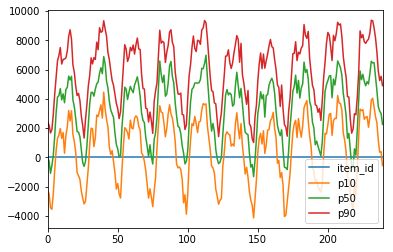

In [26]:
prophet_rel_predicts.plot()

In [27]:
# Convert the column to datetime
prophet_rel_predicts['date'] = pd.to_datetime(prophet_rel_predicts['date'])

In [28]:
# Remove the timezone and make date the index
prophet_rel_predicts['date'] = prophet_rel_predicts['date'].dt.tz_convert(None)
prophet_rel_predicts.set_index('date', inplace=True)

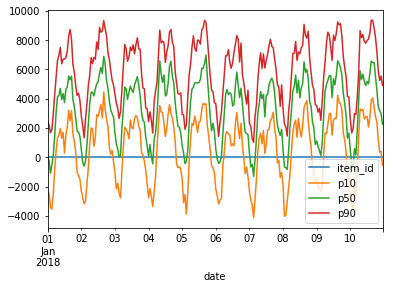

In [29]:
prophet_rel_predicts.plot()

In [30]:
prophet_rel_predicts = prophet_rel_predicts[['p10', 'p50', 'p90']]

2018-01-01 00:00:00
2018-01-20 23:00:00


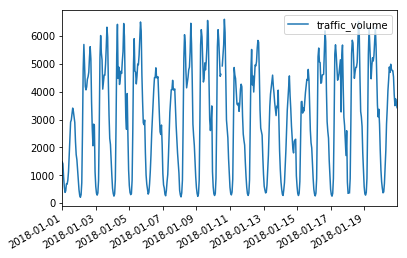

In [31]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-10']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [32]:
# Finally let us join the dataframes together
prophet_val_df = prophet_rel_predicts.join(validation_df, how='outer')

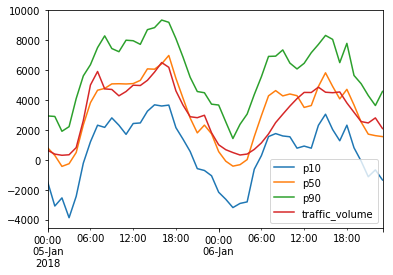

In [33]:
prophet_rel_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_rel_val_df_jan_5.plot()

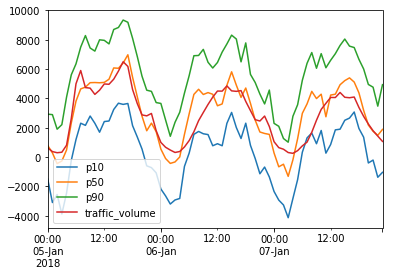

In [34]:
prophet_rel_val_df_jan_5_7 = prophet_val_df.loc['2018-01-05':'2018-01-07']
prophet_rel_val_df_jan_5_7.plot()

### DeepAR+ Validation

In [35]:
# DeepAR+ Eval
deeparp_rel_predicts = pd.read_csv(data_dir+"/"+deeparp_filename)
deeparp_rel_predicts.sample()
# Remove the timezone
deeparp_rel_predicts['date'] = pd.to_datetime(deeparp_rel_predicts['date'])
deeparp_rel_predicts['date'] = deeparp_rel_predicts['date'].dt.tz_convert(None)
deeparp_rel_predicts.set_index('date', inplace=True)
deeparp_rel_predicts = deeparp_rel_predicts[['p10', 'p50', 'p90']]
# Finally let us join the deeparp_rel_predicts together
deeparp_val_df = deeparp_rel_predicts.join(validation_df, how='outer')

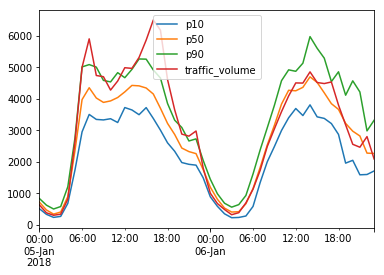

In [36]:
deeparp_rel_val_df_jan_5 = deeparp_val_df.loc['2018-01-05':'2018-01-06']
deeparp_rel_val_df_jan_5.plot()

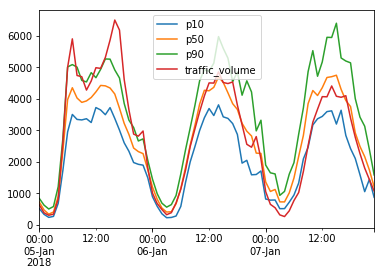

In [37]:
deeparp_rel_val_df_jan_5_7 = deeparp_val_df.loc['2018-01-05':'2018-01-07']
deeparp_rel_val_df_jan_5_7.plot()

### Comparison
* Multiple Chart Reference:
    * https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html 
    * https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots

### Prophet_Rel Vs. DeepAR+_Rel

In [38]:
def show_two_chart_horizontal(title, df1, sub_title1, df2, sub_title2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(title)

    fig.set_figwidth(16)
    fig.set_figheight(4)

    ax1.title.set_text(sub_title1)
    ax2.title.set_text(sub_title2)
    df1.plot(ax=ax1)
    df2.plot(ax=ax2)    

In [ ]:
show_two_chart_horizontal("Arima Vs. DeepAR+ with Target Data", 
                          prophet_val_df_jan_5, 
                          "Arima with target data", 
                          deeparp_val_df_jan_5,
                          "DeepAR+ with target data", 
                         )


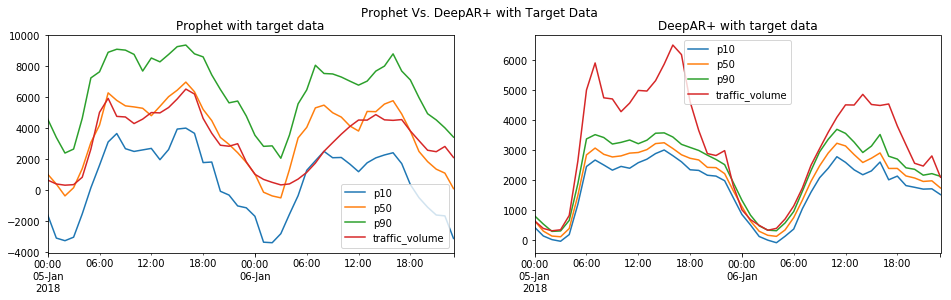

In [108]:
show_two_chart_horizontal("Prophet Vs. DeepAR+ with Target Data", 
                          prophet_val_df_jan_5, 
                          "Prophet with target data", 
                          deeparp_val_df_jan_5,
                          "DeepAR+ with target data", 
                         )


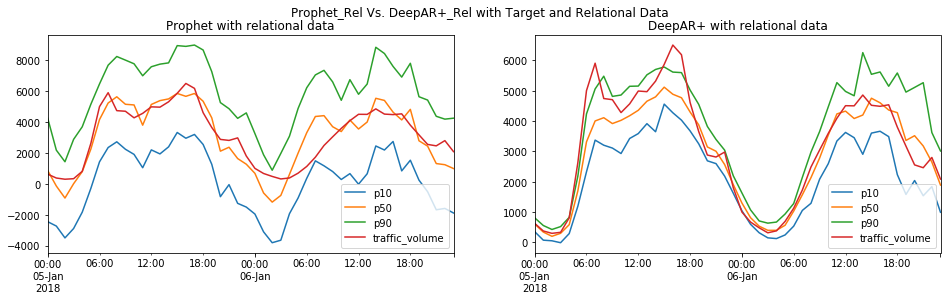

In [109]:
show_two_chart_horizontal("Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data", 
                          prophet_rel_val_df_jan_5, 
                          "Prophet with relational data", 
                          deeparp_rel_val_df_jan_5,
                          "DeepAR+ with relational data", 
                         )


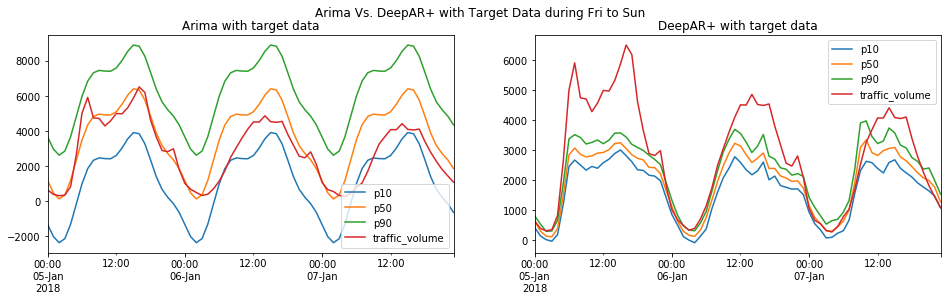

In [113]:
show_two_chart_horizontal("Arima Vs. DeepAR+ with Target Data during Fri to Sun", 
                          arima_val_df_jan_5_7, 
                          "Arima with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


### Forecasting Implication (Arima Vs. DeepAR+ with Target Data during Fri to Sun)
* 그래프 설명
    * Target Data (기간: 2017.12.12 ~ 2017.12.31) 만을 가지고 훈련된 Predictors (각각 ARIMA, DeepAR+) 를 통해서, 2018.1.1 ~ 2018.1.10 동안의 시간별 traffic volume을  예측 함. 위 기간의 예측 중에서 2018.1.5 00:00 ~ 2018.1.7 24:00 까지를 그래프로 표현 함. **실제 데이타(빨간색, traffic volume)와 p10, p50, p90 과 얼마나 간격 (잔차, Risidual) 벌어 졌는지가 보는 것으로 예측의 잘 되었는지를 그래프에서 직관적으로 확인할 수 있음.**
* 학습 관점으로 Target Data만 사용시에 Predictor의 전체 RMSE는 2315 (ARIMA), 2326(DeepAR) 로 ARIMA 가 근소하게 우수 했었음. 하지만, 예측 관점으로 DeepAR+ 의 2018.1.6 ~ 1.7 기간은 직관적으로 ARIMA 보다 우수하게 보임. 또한 DeepAR+ p10을 보면 0 정도가 최하이지만, ARIMA는 -2000 까지 낮아져서 직관적으로 성능이 나오지 않음

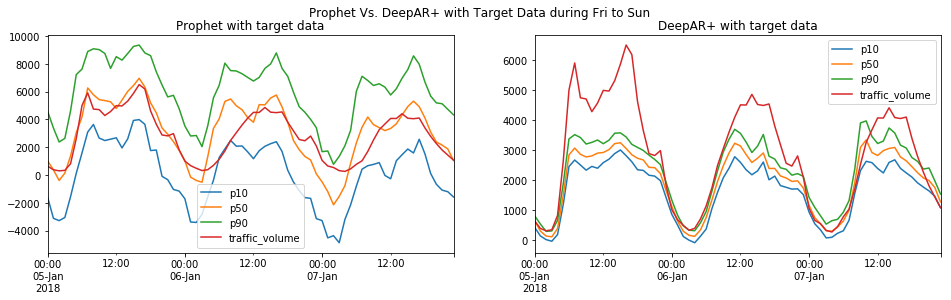

In [114]:
show_two_chart_horizontal("Prophet Vs. DeepAR+ with Target Data during Fri to Sun", 
                          prophet_val_df_jan_5_7, 
                          "Prophet with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


### Prophet Vs. DeepAR+ with Target Data during Fri to Sun)
* 그래프 설명
    * Target Data (기간: 2017.09.01 ~ 2017.12.31) 만을 가지고 훈련된 Predictors (각각 Prophet, DeepAR+) 를 통해서, 2018.1.1 ~ 2018.1.10 동안의 시간별 traffic volume을  예측 함. 위 기간의 예측 중에서 2018.1.5 00:00 ~ 2018.1.7 24:00 까지를 그래프로 표현 함. **실제 데이타(빨간색, traffic volume)와 p10, p50, p90 과 얼마나 간격 (잔차, Risidual) 벌어 졌는지가 보는 것으로 예측의 잘 되었는지를 그래프에서 직관적으로 확인할 수 있음.**
* 학습 관점으로 Target Data만 사용시에 Predictor의 전체 RMSE는 2332 (Prophet), 2326(DeepAR+) 로 DeepAR+ 가 근소하게 우수 함. Prophet 은 ARIMA와 비슷한 형태의 예측 모양을 가지고 있음. 위 그래프를 가지고 두개를 비교는 ARIMA와 비슷한 분석으로 DeepAR+ 가 좋아 보임

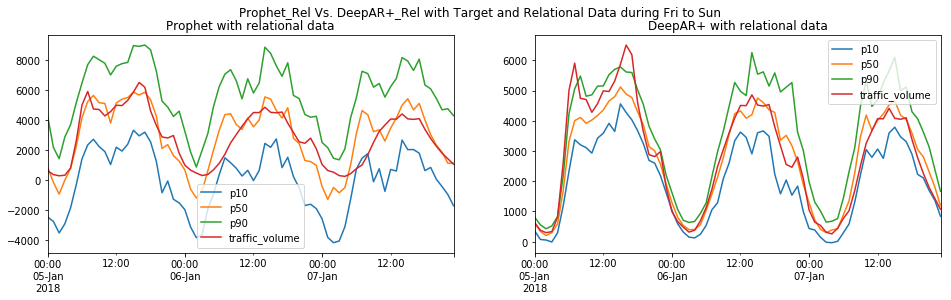

In [117]:
show_two_chart_horizontal("Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data during Fri to Sun", 
                          prophet_rel_val_df_jan_5_7, 
                          "Prophet with relational data", 
                          deeparp_rel_val_df_jan_5_7,
                          "DeepAR+ with relational data", 
                         )


### Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data during Fri to Sun)
* 그래프 설명
    * **Target Data 와 Related Data (기간: 2017.09.01 ~ 2017.12.31) 두 개의 데이타 셋 가지고 훈련된 Predictors** (각각 Prophet, DeepAR+) 를 통해서, 2018.1.1 ~ 2018.1.10 동안의 시간별 traffic volume을  예측 함. 위 기간의 예측 중에서 2018.1.5 00:00 ~ 2018.1.7 24:00 까지를 그래프로 표현 함. **실제 데이타(빨간색, traffic volume)와 p10, p50, p90 과 얼마나 간격 (잔차, Risidual) 벌어 졌는지가 보는 것으로 예측의 잘 되었는지를 그래프에서 직관적으로 확인할 수 있음.**
* 학습 관점으로 Target Data 와 Related Data를 가지고 사용된 Predictor의 전체 RMSE는 2274 (Prophet), 2195(DeepAR+) 로 DeepAR+ 가 우수 했었음. 
* 예측 관점으로 **Prophet은 Related Data를 추가해도 큰 그래프의 변화가 없으나, Related Data의 추가가 DeepAR+는 큰 폭의 안정된, 성능이 향상된 것을 확인 할 수 있음.**

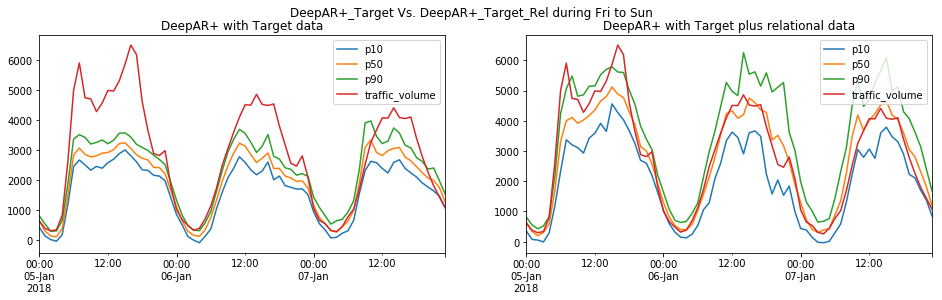

In [118]:
show_two_chart_horizontal("DeepAR+_Target Vs. DeepAR+_Target_Rel during Fri to Sun", 
                          deeparp_val_df_jan_5_7, 
                          "DeepAR+ with Target data", 
                          deeparp_rel_val_df_jan_5_7,
                          "DeepAR+ with Target plus relational data", 
                         )


### DeepAR+_Target Vs. DeepAR+_Target_Rel during Fri to Sun")
* 그래프 설명
    * **같은 기간 동안 (2017.9.1 ~ 2017.12.31) DeepAR+ 알고리즘을 왼쪽은 Target Data 만을 가지고 학습하였고, 오른쪽은 Target Data와 Related Data  두 개의 데이타 셋 가지고 훈련을 함. 각각 Predictors**를 통해서, 2018.1.1 ~ 2018.1.10 동안의 시간별 traffic volume을  예측 함. 위 기간의 예측 중에서 2018.1.5 00:00 ~ 2018.1.7 24:00 까지를 그래프로 표현 함. **실제 데이타(빨간색, traffic volume)와 p10, p50, p90 과 얼마나 간격 (잔차, Risidual) 벌어 졌는지가 보는 것으로 예측의 잘 되었는지를 그래프에서 직관적으로 확인할 수 있음.**
* 학습 관점으로 각각 Predictor의 전체 RMSE는 2326 (Target Data만 사용), 2195(Target Data + Related Data) 로 Target + Related Data가 우수 했었음. 
* 예측 관점으로 **오른쪽은 Related Data의 추가가 DeepAR+는 큰 폭의 안정된, 성능이 향상된 것을 확인 할 수 있음.**